#  Tutorial - Exploring the Data

The following section requires that:

* the tutorial has been completed
* the data from it is in the same directory

In alternative the data required to run this example can be download from [figshare](http://files.figshare.com/2598711/tutorial_data.zip) and uncrompressed.

## Imports

In [1]:
from __future__ import print_function

#Python Standard Library
import glob
import pickle
import sys

#External Dependencies (install via pip or anaconda)

# Check if running interactively or not
import matplotlib as mpl # http://matplotlib.org
# from:
# http://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
# and
# http://stackoverflow.com/questions/15455029/python-matplotlib-agg-vs-interactive-plotting-and-tight-layout
import __main__ as main
if hasattr(main, '__file__'):
    # Non interactive, force the use of Agg backend instead
    # of the default one
    mpl.use('Agg')

import numpy # http://www.numpy.org
import pandas # http://pandas.pydata.org
import seaborn # http://stanford.edu/~mwaskom/software/seaborn/
import scipy # http://www.scipy.org
import matplotlib.pyplot as plt 


#MGKit Import
from mgkit.io import gff, fasta
from mgkit.mappings import eggnog
import mgkit.counts, mgkit.taxon, mgkit.snps, mgkit.plots
import mgkit.snps
import mgkit.mappings.enzyme

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
mgkit.logger.config_log()

In [3]:
mgkit.cite(sys.stdout)


 _|      _|    _|_|_|  _|    _|  _|    _|
 _|_|  _|_|  _|        _|  _|        _|_|_|_|
 _|  _|  _|  _|  _|_|  _|_|      _|    _|
 _|      _|  _|    _|  _|  _|    _|    _|
 _|      _|    _|_|_|  _|    _|  _|      _|_|


MGKit Version: 0.2.1

Rubino, F. and Creevey, C.J. (2014).
MGkit: Metagenomic Framework For The Study Of Microbial Communities.

Available at: http://figshare.com/articles/MGkit_Metagenomic_Framework_For_The_Study_Of_Microbial_Communities/1269288

[doi:10.6084/m9.figshare.1269288]



## Download Complete Data

If the tutorial can't be completed, the download data can be downloaded from: %%

In [4]:
# the following variable is used to indicate where the tutorial data is stored
data_dir = 'tutorial-data/'

## Read Necessary Data

In [5]:
# Keeps a list of the count data file outputted by
# htseq-count
counts = glob.glob('{}*-counts.txt'.format(data_dir))

In [6]:
# This file contains the SNPs information and it is the output
# of the snp_parser script
snp_data = pickle.load(open('{}snp_data.pickle'.format(data_dir), 'r'))

In [7]:
# Taxonomy needs to be download beforehand. It is loaded into an an
# instance of mgkit.taxon.UniprotTaxonomy. It is used in filtering
# data and to map taxon IDs to different levels in the taxonomy
taxonomy = mgkit.taxon.UniprotTaxonomy('{}mg_data/taxonomy.pickle'.format(data_dir))

INFO:mgkit.taxon:Loading taxonomy from file tutorial-data/mg_data/taxonomy.pickle
2015-12-04 12:02:33,049 -    INFO - mgkit.taxon->load_data: Loading taxonomy from file tutorial-data/mg_data/taxonomy.pickle


In [8]:
# Loads all annotations in a dictionary, with the unique ID (uid) as key
# and the mgkit.io.gff.Annotation instance that represent the line in the
# GFF file as value
annotations = {x.uid: x for x in gff.parse_gff('{}assembly.uniprot.gff'.format(data_dir))}

INFO:mgkit.io.gff:Loading GFF from file (tutorial-data/assembly.uniprot.gff)
2015-12-04 12:02:47,406 -    INFO - mgkit.io.gff->parse_gff: Loading GFF from file (tutorial-data/assembly.uniprot.gff)


In [9]:
# Used to extract the sample ID from the count file names
file_name_to_sample = lambda x: x.rsplit('/')[-1].split('-')[0]

In [10]:
# Used to rename the DataFrame columns
sample_names = {
    'SRR001326': '50m',
    'SRR001325': '01m',
    'SRR001323': '32m',
    'SRR001322': '16m'
}

## Explore Count Data

### Load Taxa Table

Build a pandas.DataFrame instance. It is NOT required, but it is easier to manipulate. load_sample_counts_to_taxon returns a pandas.Series instance. 

The DataFrame will have the sample names as columns names and the  different taxon IDs as rows names. There are 3 different function to map counts and annotations to a pandas.Series instance:
    
* mgkit.counts.load_sample_counts
* mgkit.counts.load_sample_counts_to_taxon
* mgkit.counts.load_sample_counts_to_genes

The three differs primarly by the index for the pandas.Series they return, which is (gene_id, taxon_id), taxon_id and gene_id, respectively. Another change is the possibility to map a gene_id to another and a taxon_id to a different rank. In this contexts, as it is interesting to assess the abundance of each organism, mgkit.counts.load_sample_counts_to_taxon can be used. It provides a **rank** parameter that can be changed to map all counts to the *order* level in this case, but can be changed to any rank in mgkit.taxon.TAXON_RANKS, for example *genus*, *phylum*.

In [11]:
taxa_counts = pandas.DataFrame({
    # Get the sample names
    file_name_to_sample(file_name): mgkit.counts.load_sample_counts_to_taxon(
        # A function accept a uid as only parameter and returns only the 
        # gene_id and taxon_id, so we set it to a lambda that does
        # exactly that
        lambda x: (annotations[x].gene_id, annotations[x].taxon_id),
        # An iterator that yields (uid, count) is needed and MGKit
        # has a function that does that for htseq-count files.
        # This can be adapted to any count data file format
        mgkit.counts.load_htseq_counts(file_name),
        # A mgkit.taxon.UniprotTaxonomy instance is necessary to filter
        # the data and map it to a different rank
        taxonomy,
        # A taxonomic rank to map each taxon_id to. Must be lowercase
        rank='order',
        # If False, any taxon_id that can not be resolved at the taxonomic
        # rank requested is excluded from the results
        include_higher=False
    )
    # iterate over all count files
    for file_name in counts
})

INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
2015-12-04 12:02:47,882 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
2015-12-04 12:02:47,963 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
2015-12-04 12:02:48,041 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001326-counts.txt
2015-12-04 12:02:48,118 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001326-counts.txt


#### Scaling (DESeq method) and Rename Rows/Columns

Because each sample has different yields in total DNA from the sequencing, the table should be scaled. The are a few approaches, RPKM, scaling by the minimum. MGKit offers mgkit.counts.scaling.scale_factor_deseq and mgkit.counts.scaling.scale_rpkm that scale using the DESeq method and RPKM respectively.

In [12]:
# the DESeq method doesn't require information about the gene length
taxa_counts = mgkit.counts.scale_deseq(taxa_counts)

One of the powers of pandas data structures is the metadata associated and the possibility to modify them with ease.
In this case, the columns are named after the sample IDs from ENA and the row names are the taxon IDs. To make it easier to analyse, columns and rows can be renamed and sorted by name and the rows sorted in descending order by the first colum (1 meter).

To rename the columns the dictionary **sample_name** can be supplied and for the rows the name of each taxon ID can be accessed through the taxonomy instance, because it works as a dictionary and the returned object has a **s_name** attribute with the scientific name (lowercase).

In [13]:
# Sorting is done through pandas
taxa_counts = taxa_counts.rename(
    index=lambda x: taxonomy[x].s_name,
    columns=sample_names
).sort(axis='columns').sort(['01m'], ascending=False)

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [14]:
# the *describe* method of a pandas.Series or pandas.DataFrame
# gives some insights into the data
taxa_counts.describe()

,01m,16m,32m,50m
count,174.000000,174.000000,174.000000,174.000000
mean,32.074193,37.005129,34.355541,38.486366
std,75.836221,97.136199,90.514214,97.525346
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.177828,0.000000
50%,5.551763,4.207739,4.979182,4.761046
75%,23.594992,24.457482,21.872837,25.103697
max,549.624516,713.211745,711.311764,737.529306


In [15]:
#Save a CSV to disk, but Excel and other file formats are available
taxa_counts.to_csv('{}taxa_counts.csv'.format(data_dir))

In [16]:
# This will give an idea of the counts for each order
taxa_counts.iloc[:20]

,01m,16m,32m,50m
methanococcales,549.624516,713.211745,711.311764,737.529306
bacillales,545.460694,547.006058,439.590670,528.043283
thermococcales,367.804284,629.056967,576.162529,594.697927
clostridiales,234.561978,214.594684,207.703035,206.023445
archaeoglobales,216.518749,309.268810,277.411588,274.409378
dehalococcoidales,210.966986,226.165966,285.947329,253.633905
enterobacteriales,206.803164,163.049883,146.530223,252.768260
methanobacteriales,169.328765,353.450068,290.215200,330.676285
actinomycetales,166.552884,148.322797,115.232506,141.100090
methanosarcinales,152.673477,235.633379,213.393529,128.981064


### Plots for Top40 Taxa

#### Distribution of Each Taxon Over Depth

How to visualise the data depends on the question we want to ask and the experimental design. As a starting point, it may be interesting to visualise the variation of a taxonomic order abundance over the samples. This can be done using boxplots, among other methods. 

MGKit offers a few functions to make complex plots, with a starting point in mgkit.plots.boxplot.boxplot_dataframe. However, as the data produced is in fact a pandas DataFrame, which is widely supported, a host of different specialised libraries tht offer similar functions can be used.

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


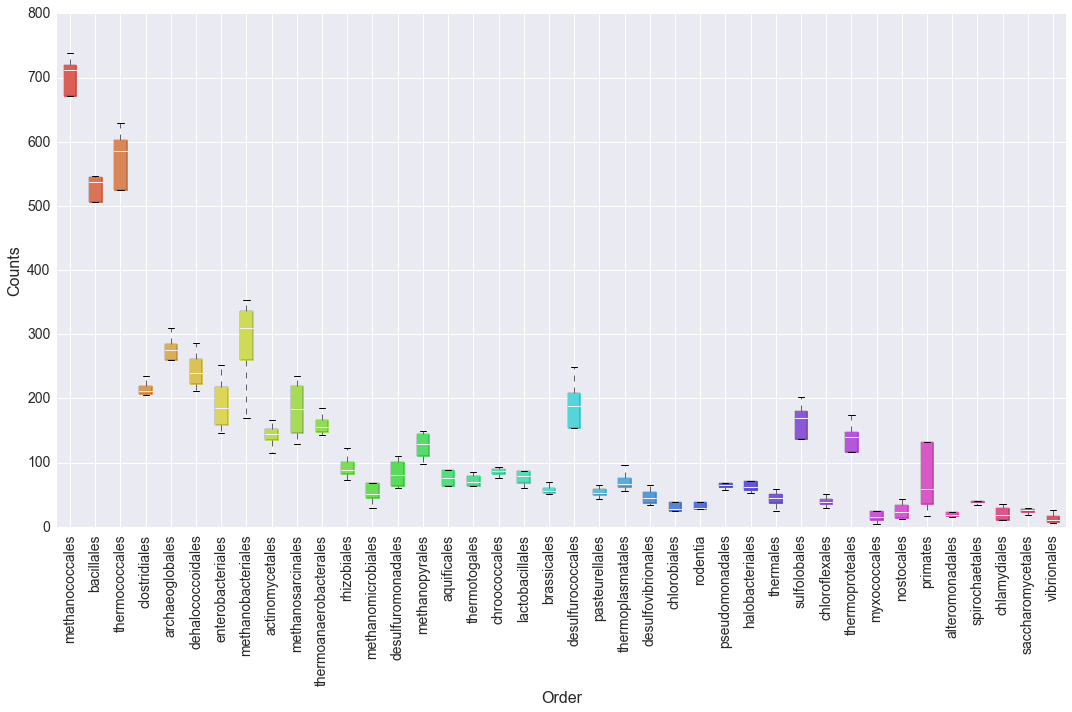

In [17]:
# A matplotlib Figure instance and a single axis can be returned 
# by this MGKit function. It is an helper function, the axis is
# needed to plot and the figure object to save the file to disk
fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
# The return value of mgkit.plots.boxplot.boxplot_dataframe is 
# passed to the **_** special variable, as it is not needed and
# it would be printed, otherwise
_ = mgkit.plots.boxplot.boxplot_dataframe(
    # The full dataframe can be passed
    taxa_counts, 
    # this variable is used to tell the function
    # which rows and in which order they need to
    # be plot. In this case only the first 40 are
    # plot
    taxa_counts.index[:40],
    # A matplotlib axis instance
    ax, 
    # a dictionary with options related to the labels
    # on both the X and Y axes. In this case it changes
    # the size of the labels
    fonts=dict(fontsize=14),
    # The default is to use the same colors for all
    # boxes. A dictionary can be passed to change this
    # in this case, the 'hls' palette from seaborn is
    # used.
    data_colours={
        x: color
        for x, color in zip(taxa_counts.index[:40], seaborn.color_palette('hls', 40))
    }
)
# Adds labels to the axes
ax.set_xlabel('Order', fontsize=16)
ax.set_ylabel('Counts', fontsize=16)
# Ensure the correct layout before writing to disk
fig.set_tight_layout(True)
# Saves a PDF file, or any other supported format by matplotlib
fig.savefig('{}taxa_counts-boxplot_top40_taxa.pdf'.format(data_dir))

#### Distribution of Taxa at Each Depth

Seaborn offers a KDE plot, which is useful to display the distribution of taxa counts for each sampling depth.

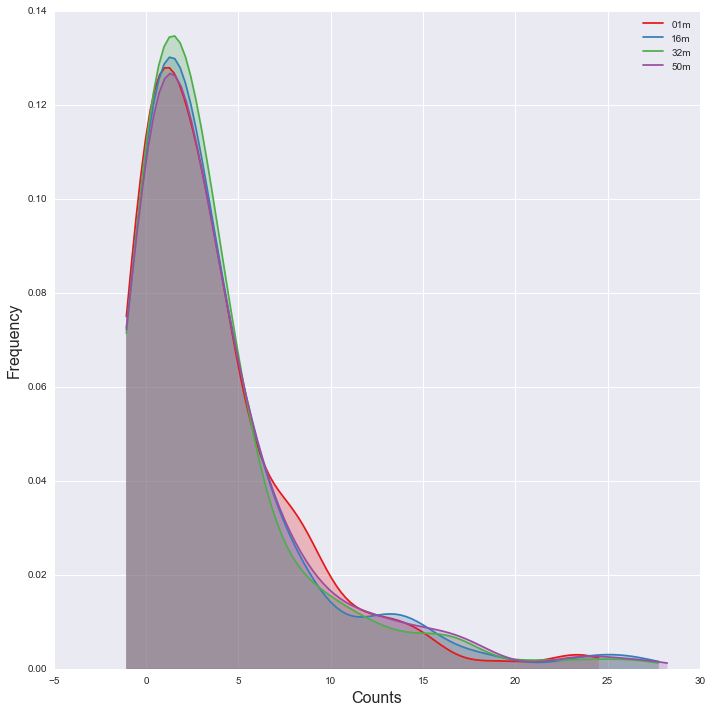

In [18]:
fig, ax = mgkit.plots.get_single_figure(figsize=(10, 10))
# iterate over the columns, which are the samples and assign a color to each one
for column, color in zip(taxa_counts.columns, seaborn.color_palette('Set1', len(taxa_counts.columns))):
    seaborn.kdeplot(
        # The data can transformed with the sqrt function of numpy
        numpy.sqrt(taxa_counts[column]),
        # Assign the color
        color=color,
        # Assign the label to the sample name to appear
        # in the legend
        label=column,
        # Add a shade under the KDE function
        shade=True
    )
# Adds a legend
ax.legend()
ax.set_xlabel('Counts', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
fig.set_tight_layout(True)
fig.savefig('{}taxa_counts-distribution_top40_taxa.pdf'.format(data_dir))

#### Heatmap of the Table

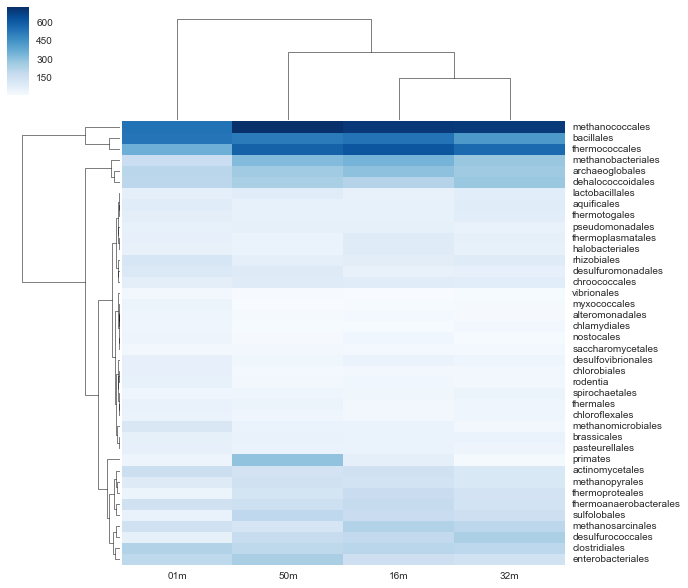

In [19]:
# An heatmap can be created to provide information on the table
clfig = seaborn.clustermap(taxa_counts.iloc[:40], cbar=True, cmap='Blues')
clfig.fig.set_tight_layout(True)
for text in clfig.ax_heatmap.get_yticklabels():
    text.set_rotation('horizontal')
clfig.savefig('{}taxa_counts-heatmap-top40.pdf'.format(data_dir))

### Functional Categories

Besides looking at specific taxa, it is possible to map each gene_id to functional categories. [eggNOG](http://eggnog.embl.de/) provides this. **v3 must be used**, as the mappings in Uniprot points to that version.

#### Load Necessary Data

In [20]:
eg = eggnog.NOGInfo()

In [21]:
# Just a few to speed up the analysis, but other can be used
# Should have been downloaded by the full tutorial script
eg.load_members('{}COG.members.txt.gz'.format(data_dir))
eg.load_members('{}NOG.members.txt.gz'.format(data_dir))
eg.load_funccat('{}COG.funccat.txt.gz'.format(data_dir))
eg.load_funccat('{}NOG.funccat.txt.gz'.format(data_dir))

INFO:mgkit.mappings.eggnog:Reading Members from tutorial-data/COG.members.txt.gz
2015-12-04 12:02:51,730 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-data/COG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Members from tutorial-data/NOG.members.txt.gz
2015-12-04 12:03:08,104 -    INFO - mgkit.mappings.eggnog->load_members: Reading Members from tutorial-data/NOG.members.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-data/COG.funccat.txt.gz
2015-12-04 12:03:18,667 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-data/COG.funccat.txt.gz
INFO:mgkit.mappings.eggnog:Reading Functional Categories from tutorial-data/NOG.funccat.txt.gz
2015-12-04 12:03:18,683 -    INFO - mgkit.mappings.eggnog->load_funccat: Reading Functional Categories from tutorial-data/NOG.funccat.txt.gz


In [22]:
#Build mapping Uniprot IDs -> eggNOG functional categories
fc_map = {
    # An Annotation instance provide a method to access the list of IDs for the
    # specific mapping. For example eggnog mappings are store into the
    # map_EGGNOG attribute
    annotation.gene_id: eg.get_nogs_funccat(annotation.get_mapping('eggnog'))
    for annotation in annotations.itervalues()
}

#### Build FC Table

As mentioned above, mgkit.counts.load_sample_counts_to_genes works in the same way as mgkit.counts.load_sample_counts_to_taxon, with the difference of giving **gene_id** as the only index.

In this case, however, as a mapping to functional categories is wanted, to the **gene_map** parameter a dictionary where for each *gene_id* an iterable of *mappings* is assigned. These are the values used in the index of the returned pandas.Series, which ends up as rows in the **fc_counts** DataFrame.

In [23]:
fc_counts = pandas.DataFrame({
    file_name_to_sample(file_name): mgkit.counts.load_sample_counts_to_genes(
        lambda x: (annotations[x].gene_id, annotations[x].taxon_id),
        mgkit.counts.load_htseq_counts(file_name),
        taxonomy,
        gene_map=fc_map
    )
    for file_name in counts
})

INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
2015-12-04 12:03:18,997 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
2015-12-04 12:03:22,464 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
2015-12-04 12:03:22,534 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001326-counts.txt
2015-12-04 12:03:22,602 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001326-counts.txt


#### Scale the Table and Rename Rows/Columns

In [24]:
fc_counts = mgkit.counts.scale_deseq(fc_counts).rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [25]:
fc_counts.describe()

,16m,32m,01m,50m
count,23.000000,23.000000,23.000000,23.000000
mean,273.816652,277.187909,234.120394,273.820931
std,277.374757,276.552505,184.622466,273.784212
min,0.000000,0.000000,0.000000,3.454206
25%,63.494395,77.757406,109.782606,65.198142
50%,206.625826,230.915934,218.209872,222.796298
75%,340.071673,375.434750,317.149751,357.942115
max,1110.613817,1153.008815,708.843248,1172.702997


In [26]:
fc_counts

,16m,32m,01m,50m
RNA processing and modification,4.304705,3.141713,24.396135,44.904680
Chromatin structure and dynamics,27.980581,21.991994,12.198067,66.493469
Energy production and conversion,664.000702,571.791837,481.145990,580.306638
"Cell cycle control, cell division, chromosome partitioning",65.646747,87.182547,112.493288,49.222438
Amino acid transport and metabolism,655.391293,651.120100,539.425646,534.538406
Nucleotide transport and metabolism,322.852854,367.580467,253.448733,278.063597
Carbohydrate transport and metabolism,306.710211,336.163333,241.250666,270.291633
Coenzyme transport and metabolism,298.100802,290.608489,344.256568,338.512205
Lipid transport and metabolism,218.463764,230.915934,231.763280,222.796298
"Translation, ribosomal structure and biogenesis",1110.613817,1153.008815,708.843248,1172.702997


In [27]:
#Save table to disk
fc_counts.to_csv('{}fc_counts.csv'.format(data_dir))

#### Heatmap to Explore Functional Categories

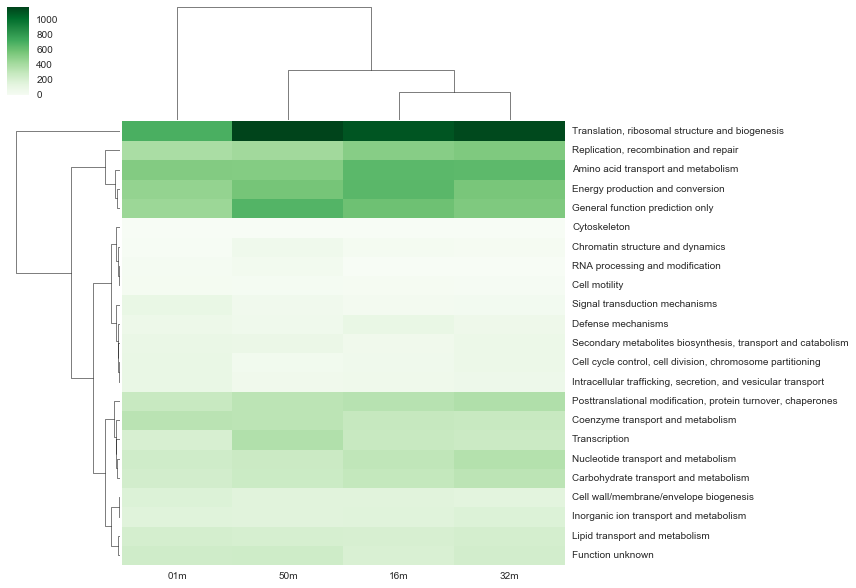

In [28]:
clfig = seaborn.clustermap(fc_counts, cbar=True, cmap='Greens')
clfig.fig.set_tight_layout(True)
for text in clfig.ax_heatmap.get_yticklabels():
    text.set_rotation('horizontal')
clfig.savefig('{}fc_counts-heatmap.pdf'.format(data_dir))

### Enzyme Classification

Enzyme classification number were added the *add-gff-info* script, so they can be used in a similar way to functional categories. The specificity level requested is **2**.

In [29]:
ec_map = {
    # EC numbers are store into the EC attribute in a GFF file and
    # an Annotation instance provide a get_ec method that returns
    # a list. A level of specificity can be used to the mapping
    # less specific, as it ranges from 1 to 4 included. Right
    # now a list is returned, so it is a good idea to convert
    # the list into a set so if any duplicate appears (as effect
    # of the change in level) it won't inflate the number later.
    # In later versions (0.2) a set will be returned instead of 
    # a list.
    # We also want to remove any hanging ".-" to use the labels
    # from expasy
    annotation.gene_id: set(x.replace('.-', '') for x in annotation.get_ec(level=2))
    for annotation in annotations.itervalues()
}

In [30]:
# The only difference with the functional categories is the mapping
# used.
ec_counts = pandas.DataFrame({
    file_name_to_sample(file_name): mgkit.counts.load_sample_counts_to_genes(
        lambda x: (annotations[x].gene_id, annotations[x].taxon_id),
        mgkit.counts.load_htseq_counts(file_name),
        taxonomy,
        gene_map=ec_map
    )
    for file_name in counts
})

INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
2015-12-04 12:03:23,723 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001322-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
2015-12-04 12:03:23,799 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001323-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
2015-12-04 12:03:23,871 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001325-counts.txt
INFO:mgkit.counts.func:Loading HTSeq-count file tutorial-data/SRR001326-counts.txt
2015-12-04 12:03:23,944 -    INFO - mgkit.counts.func->load_htseq_counts: Loading HTSeq-count file tutorial-data/SRR001326-counts.txt


In [31]:
# This file contains the names of each enzyme class and can be downloaded
# from ftp://ftp.expasy.org/databases/enzyme/enzclass.txt
# It should be downloaded at the end of the tutorial script
ec_names = mgkit.mappings.enzyme.parse_expasy_file('{}enzclass.txt'.format(data_dir))

In [32]:
# Rename columns and row. Rows will include the full label the enzyme class
ec_counts = mgkit.counts.scale_deseq(ec_counts).rename(
    index=lambda x: "{} {} [EC {}.-]".format(
        # A name of the second level doesn't include the first level
        # definition, so if it is level 2, we add the level 1 label
        '' if len(x) == 1 else ec_names[x[0]] + " - ",
        # The EC label for the specific class (e.g. 3.2)
        ec_names[x],
        # The EC number
        x
    ), 
    columns=sample_names
)

In [33]:
plot_order = ec_counts.median(axis=1).sort(ascending=True, inplace=False).index

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [34]:
ec_counts.describe()

,16m,32m,01m,50m
count,54.000000,54.000000,54.000000,54.000000
mean,78.246490,83.067825,87.597334,85.266871
std,97.540115,108.125992,111.697308,116.080646
min,0.000000,0.000000,0.000000,0.000000
25%,9.006159,9.193469,10.050119,5.331236
50%,42.660752,49.156918,48.575576,42.649890
75%,115.421034,112.010228,125.207734,127.949671
max,456.944053,533.596465,551.081530,663.738916


In [35]:
ec_counts

,16m,32m,01m,50m
Oxidoreductases [EC 1.-],26.544468,15.760233,46.900556,52.423823
Oxidoreductases - Acting on the CH-OH group of donors [EC 1.1.-],158.318790,132.836251,222.777640,163.491246
Oxidoreductases - Acting on a peroxide as acceptor [EC 1.11.-],6.636117,14.259259,0.000000,3.554158
Oxidoreductases - Acting on hydrogen as donor [EC 1.12.-],64.465136,81.052628,53.600635,46.204048
Oxidoreductases - Acting on single donors with incorporation of molecular oxygen [EC 1.13.-],0.000000,7.504873,6.700079,3.554158
"Oxidoreductases - Acting on paired donors, with incorporation or reduction of molecular oxygen [EC 1.14.-]",0.948017,4.502924,0.000000,1.777079
Oxidoreductases - Acting on superoxide as acceptor [EC 1.15.-],4.740084,3.001949,0.000000,2.665618
Oxidoreductases - Oxidizing metal ions [EC 1.16.-],14.220251,10.506822,3.350040,11.551012
Oxidoreductases - Acting on CH or CH(2) groups [EC 1.17.-],36.972652,37.524365,73.700873,25.767642
Oxidoreductases - Acting on iron-sulfur proteins as donors [EC 1.18.-],31.284551,11.257309,11.725139,36.430115


In [36]:
ec_counts.to_csv('{}ec_counts.csv'.format(data_dir))

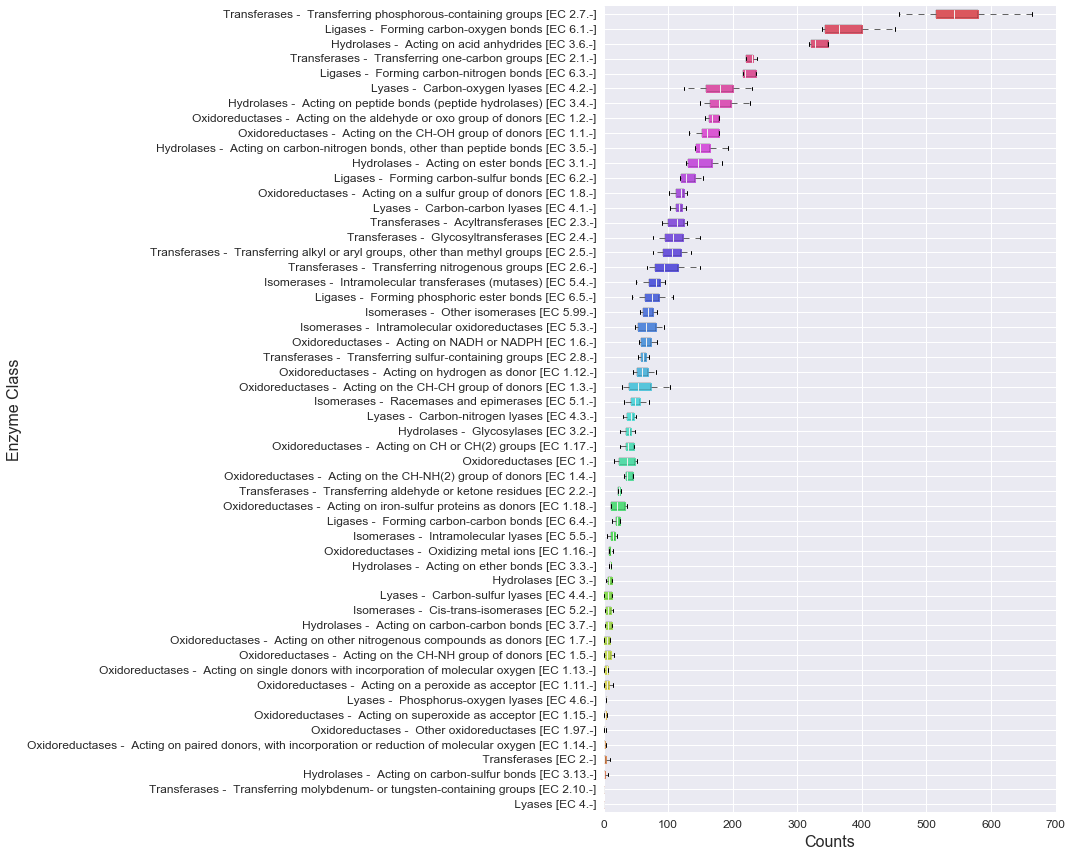

In [37]:
fig, ax = mgkit.plots.get_single_figure(figsize=(15, 12))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_counts, 
    plot_order,
    ax, 
    # a dictionary with options related to the labels
    # on both the X and Y axes. In this case it changes
    # the size of the labels and the rotation - the default
    # is 'vertical', as the box_vert=True by default
    fonts=dict(fontsize=12, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(plot_order)))
    },
    # Changes the direction of the boxplot. The rotation of 
    # the labels must be set to 'horizontal' in the *fonts*
    # dictionary
    box_vert=False
)
# Adds labels to the axes
ax.set_xlabel('Counts', fontsize=16)
ax.set_ylabel('Enzyme Class', fontsize=16)
# Ensure the correct layout before writing to disk
fig.set_tight_layout(True)
# Saves a PDF file, or any other supported format by matplotlib
fig.savefig('{}ec_counts-boxplot.pdf'.format(data_dir))

## Explore Diversity

Diversity in metagenomic samples can be analysed using pN/pS values. The data required to do this was produced in the tutorial by the *snp_parser* script. Here are some examples of how to calculate diversity estimates from this data.

The complete toolset to map diversity estimates can be found in the **mgkit.snps** package, with the *mgkit.snps.funcs.combine_sample_snps* function building the final pandas DataFrame. As the use of the function requires the initialisation of different functions, a few easier to use ones are available in the **mgkit.snps.conv_func** module:

* get_rank_dataframe
* get_gene_map_dataframe
* get_full_dataframe
* get_gene_taxon_dataframe

The first is used to get diversity estimates for taxa, the second for genes/functions. The other two provides functionality to return estimates tied to both taxon and function.

### Taxa

In [38]:
# Sets the minimum coverage for an annotation to be
# included into the table (defaults to 4)
mgkit.consts.DEFAULT_SNP_FILTER['min_cov'] = 4

In [39]:
# To get diversity estimates for taxa *mgkit.snps.conv_func.get_rank_dataframe* can be used
# It is also imported and accesible from the *mgkit.snps* package
pnps = mgkit.snps.get_rank_dataframe(snp_data, taxonomy, min_num=3, rank='order', index_type='taxon')

INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001322
2015-12-04 12:03:26,735 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001322
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001323
2015-12-04 12:03:26,750 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001323
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001325
2015-12-04 12:03:26,765 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001325
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001326
2015-12-04 12:03:26,781 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001326


In [40]:
pnps = pnps.rename(
    columns=sample_names,
    index=lambda x: taxonomy[x].s_name
)

In [41]:
pnps.describe()

,16m,32m,01m,50m
count,27.000000,27.000000,32,31.000000
mean,0.026988,0.051995,0,0.011640
std,0.101008,0.136425,0,0.064806
min,0.000000,0.000000,0,0.000000
25%,0.000000,0.000000,0,0.000000
50%,0.000000,0.000000,0,0.000000
75%,0.000000,0.000000,0,0.000000
max,0.462963,0.526316,0,0.360825


In [42]:
pnps

,16m,32m,01m,50m
methanococcales,0.000000,NaN,0,0.000000
spirochaetales,NaN,0.000000,0,0.000000
saccharomycetales,NaN,0.000000,0,0.000000
thermales,NaN,0.000000,0,0.000000
dehalococcoidales,0.000000,0.247024,0,0.000000
desulfuromonadales,0.000000,0.000000,0,0.000000
rhodobacterales,0.000000,NaN,0,0.000000
schizosaccharomycetales,0.265700,0.000000,0,0.000000
clostridiales,0.000000,0.215054,0,0.000000
archaeoglobales,0.000000,0.000000,0,NaN


In [43]:
pnps.to_csv('{}pnps-taxa.csv'.format(data_dir))

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


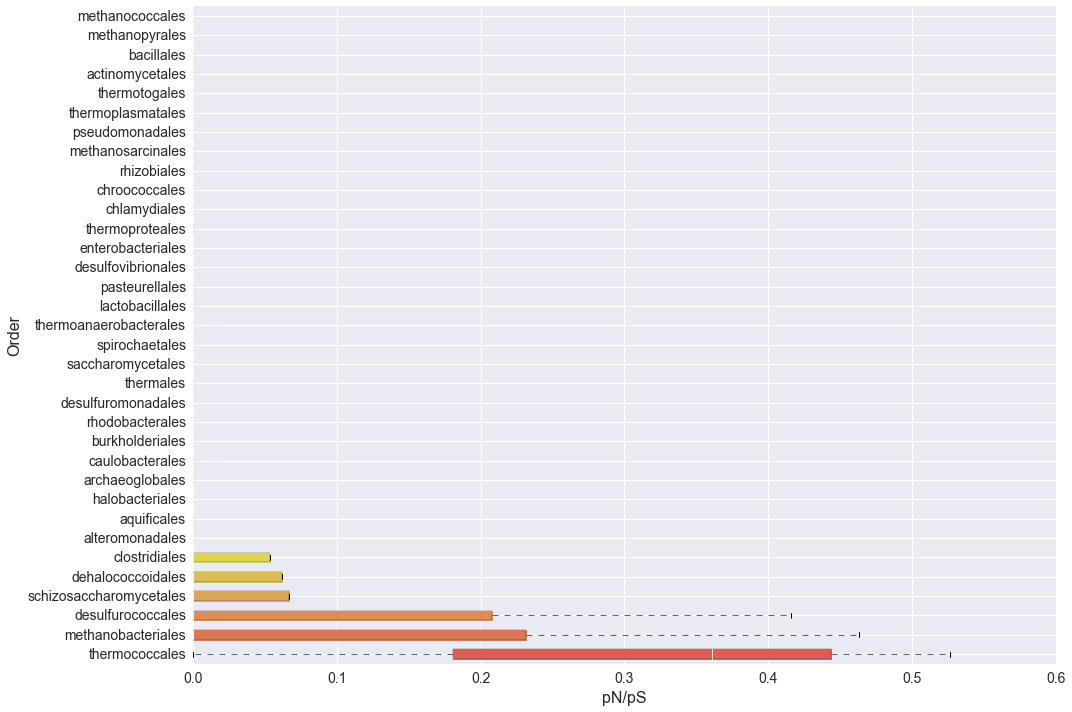

In [44]:
#sort the DataFrame to plot them by mean value
plot_order = pnps.mean(axis=1).sort(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(pnps.index)))
    },
    box_vert=False
)
ax.set_xlabel('pN/pS', fontsize=16)
ax.set_ylabel('Order', fontsize=16)
fig.set_tight_layout(True)
fig.savefig('{}pnps-taxa-boxplot.pdf'.format(data_dir))

### Functional Categories

In [45]:
# To get diversity estimates of functions, *mgkit.snps.conv_func.get_gene_map_dataframe* can be used
# This is available in the *mgkit.snps* package as well
fc_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=fc_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001322
2015-12-04 12:03:27,978 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001322
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001323
2015-12-04 12:03:27,990 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001323
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001325
2015-12-04 12:03:28,001 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001325
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001326
2015-12-04 12:03:28,014 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001326


In [46]:
fc_pnps = fc_pnps.rename(
    columns=sample_names,
    index=eggnog.EGGNOG_CAT
)

In [47]:
fc_pnps.describe()

,16m,32m,01m,50m
count,17.000000,14.000000,17,15.000000
mean,0.070573,0.125543,0,0.110016
std,0.232245,0.261492,0,0.282747
min,0.000000,0.000000,0,0.000000
25%,0.000000,0.000000,0,0.000000
50%,0.000000,0.000000,0,0.000000
75%,0.000000,0.146028,0,0.000000
max,0.937500,0.950649,0,0.932642


In [48]:
fc_pnps

,16m,32m,01m,50m
Energy production and conversion,0.262241,0.163082,0,0.932642
Amino acid transport and metabolism,0.000000,0.000000,0,0.000000
Carbohydrate transport and metabolism,0.000000,0.000000,0,0.000000
Nucleotide transport and metabolism,0.000000,0.373333,0,0.000000
Lipid transport and metabolism,0.000000,0.000000,0,0.000000
Transcription,0.000000,0.000000,0,0.000000
"Translation, ribosomal structure and biogenesis",0.000000,NaN,0,0.653333
Cell wall/membrane/envelope biogenesis,0.000000,0.000000,0,NaN
"Replication, recombination and repair",0.937500,NaN,0,0.000000
"Posttranslational modification, protein turnover, chaperones",0.000000,0.950649,0,0.064260


In [49]:
fc_pnps.to_csv('{}pnps-fc.csv'.format(data_dir))

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


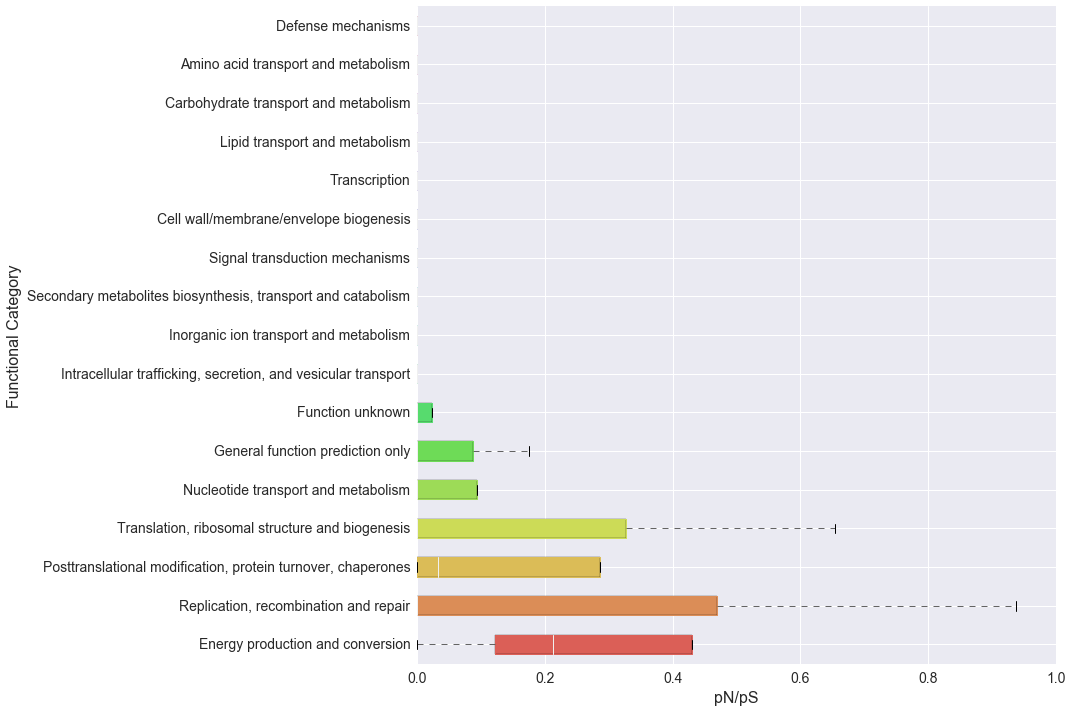

In [50]:
#sort the DataFrame to plot them by median value
plot_order = fc_pnps.mean(axis=1).sort(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    fc_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(fc_pnps.index)))
    },
    box_vert=False
)
ax.set_xlabel('pN/pS', fontsize=16)
ax.set_ylabel('Functional Category', fontsize=16)
fig.set_tight_layout(True)
fig.savefig('{}pnps-fc-boxplot.pdf'.format(data_dir))

### Enzyme Classification

In [51]:
ec_map = {
    # Using only the first level
    annotation.gene_id: set(x.replace('.-', '') for x in annotation.get_ec(level=1))
    for annotation in annotations.itervalues()
}

In [52]:
ec_pnps = mgkit.snps.get_gene_map_dataframe(snp_data, taxonomy, min_num=3, gene_map=ec_map, index_type='gene')

INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001322
2015-12-04 12:03:28,953 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001322
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001323
2015-12-04 12:03:28,965 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001323
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001325
2015-12-04 12:03:28,974 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001325
INFO:mgkit.snps.funcs:Analysing SNP from sample SRR001326
2015-12-04 12:03:28,984 -    INFO - mgkit.snps.funcs->combine_sample_snps: Analysing SNP from sample SRR001326


In [53]:
# Rename columns and row. Rows will include the full label the enzyme class
ec_pnps = ec_pnps.rename(
    index=lambda x: "{} {} [EC {}.-]".format(
        # A name of the second level doesn't include the first level
        # definition, so if it is level 2, we add the level 1 label
        '' if len(x) == 1 else ec_names[x[0]] + " - ",
        # The EC label for the specific class (e.g. 3.2)
        ec_names[x],
        # The EC number
        x
    ), 
    columns=sample_names
)

In [54]:
ec_pnps.describe()

,16m,32m,01m,50m
count,4.000000,4.000000,4,5.000000
mean,0.358054,0.196144,0,0.309847
std,0.386389,0.392287,0,0.439112
min,0.000000,0.000000,0,0.000000
25%,0.153361,0.000000,0,0.000000
50%,0.265464,0.000000,0,0.000000
75%,0.470157,0.196144,0,0.614564
max,0.901288,0.784574,0,0.934673


In [55]:
ec_pnps

,16m,32m,01m,50m
Oxidoreductases [EC 1.-],0.326446,0.000000,0,0.934673
Transferases [EC 2.-],NaN,0.784574,0,0.614564
Isomerases [EC 5.-],0.901288,NaN,0,0.000000
Lyases [EC 4.-],0.000000,0.000000,NaN,0.000000
Ligases [EC 6.-],0.204482,0.000000,0,0.000000


In [56]:
ec_pnps.to_csv('{}pnps-ec.csv'.format(data_dir))

/Users/francesco/dev/dev-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


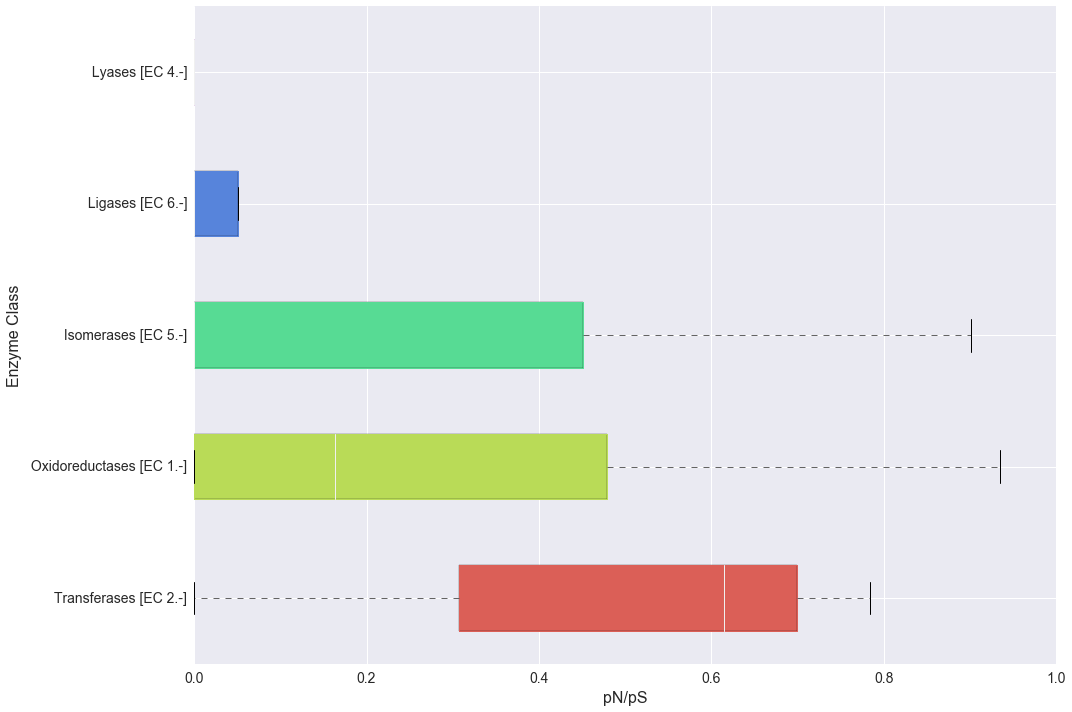

In [57]:
#sort the DataFrame to plot them by median value
plot_order = ec_pnps.mean(axis=1).sort(inplace=False, ascending=False).index

fig, ax = mgkit.plots.get_single_figure(figsize=(15, 10))
_ = mgkit.plots.boxplot.boxplot_dataframe(
    ec_pnps, 
    plot_order, 
    ax, 
    fonts=dict(fontsize=14, rotation='horizontal'),
    data_colours={
        x: color
        for x, color in zip(plot_order, seaborn.color_palette('hls', len(plot_order)))
    },
    box_vert=False
)
ax.set_xlabel('pN/pS', fontsize=16)
ax.set_ylabel('Enzyme Class', fontsize=16)
fig.set_tight_layout(True)
fig.savefig('{}pnps-ec-boxplot.pdf'.format(data_dir))